In [245]:
import seaborn as sns
from utils.k_means import KMeans, Cluster
from PIL import Image
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from skimage.color import rgb2gray, rgb2lab, lab2rgb
import numpy as np
%matplotlib inline
from sklearn.datasets import fetch_mldata


## We can use K-Means to extract a color palette from an image

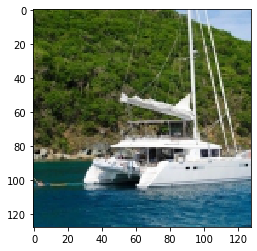

In [246]:
original = mpimg.imread('data/380_128.jpg').astype(np.float64)/255
plt.imshow(original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


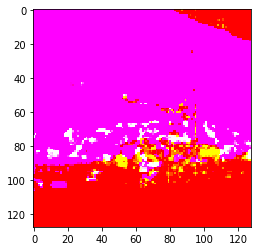

In [247]:
lab = rgb2lab(original)
print(lab.shape)
plt.imshow(lab)

(128, 128)


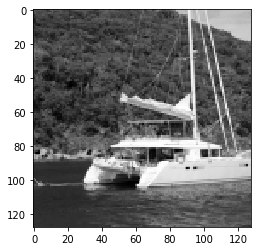

In [248]:
grayscale = rgb2gray(original)
print(grayscale.shape)
plt.imshow(grayscale, cmap='gray')

In [249]:
original_points = original.reshape((original.shape[0]*original.shape[1]), original.shape[2])
print("Original")
print(original_points)

print("LAB")
lab_points = lab.reshape((lab.shape[0]*lab.shape[1]), 3)
print(lab_points)

print("Grayscale")
grayscale_points = grayscale.reshape((grayscale.shape[0]*grayscale.shape[1]), 1)
print(grayscale_points)



Original
[[0.31372549 0.40784314 0.11764706]
 [0.29411765 0.38431373 0.10196078]
 [0.2745098  0.37647059 0.09803922]
 ...
 [0.05098039 0.27058824 0.4       ]
 [0.02352941 0.23529412 0.36862745]
 [0.01568627 0.23529412 0.37254902]]
LAB
[[ 40.73499154 -21.01328756  37.15322139]
 [ 38.38572946 -20.38402817  36.37275875]
 [ 37.36796109 -21.61379461  35.65554087]
 ...
 [ 27.57427713  -4.41135937 -24.21182698]
 [ 23.92788496  -2.48799275 -24.80735437]
 [ 23.9446961   -2.25441084 -25.43466158]]
Grayscale
[[0.36692   ]
 [0.34478941]
 [0.33472902]
 ...
 [0.23325216]
 [0.19990745]
 [0.19852353]]


In [190]:
%%time
kmeans_rgb = KMeans(n_clusters=64)
kmeans_rgb.fit(original_points)


kmeans_lab = KMeans(n_clusters=64)
kmeans_lab.fit(lab_points)


kmeans_grayscale = KMeans(n_clusters=64)
kmeans_grayscale.fit(grayscale_points)

CPU times: user 32.4 s, sys: 85.3 ms, total: 32.5 s
Wall time: 32.6 s


In [191]:
original_transformed = np.array(kmeans_rgb.transform(original_points)).reshape(original.shape[0], original.shape[1], original.shape[2])
lab_transformed = np.array(kmeans_lab.transform(lab_points)).reshape(lab.shape[0], lab.shape[1], lab.shape[2])
grayscale_transformed = np.array(kmeans_grayscale.transform(grayscale_points)).reshape(grayscale.shape[0], grayscale.shape[1])

In [192]:
print(original_transformed.shape)
print(lab_transformed.shape)
print(grayscale_transformed.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128)


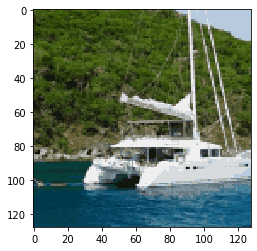

In [193]:
plt.imshow(original_transformed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


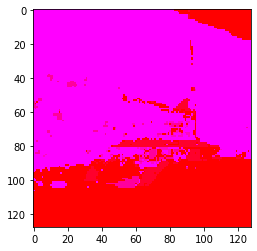

In [194]:
plt.imshow(lab_transformed)

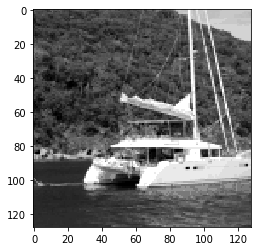

In [195]:
plt.imshow(grayscale_transformed, cmap='gray')

In [196]:
gray2lab = dict(zip(np.array(kmeans_grayscale.get_centers()).flatten(), tuple(kmeans_lab.get_centers())))
gray2rgb = dict(zip(np.array(kmeans_grayscale.get_centers()).flatten(), tuple(kmeans_rgb.get_centers())))

(128, 128, 3)


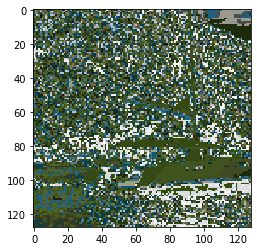

In [197]:
grayscale2lab = np.zeros((original.shape[0], original.shape[1], 3))

for i in range(grayscale_transformed.shape[0]):
    for j in range(grayscale_transformed.shape[1]):
        grayscale2lab[i,j] = gray2lab[grayscale_transformed[i,j]]
        
back2rgb = lab2rgb(grayscale2lab)
print(back2rgb.shape)
plt.imshow(back2rgb)

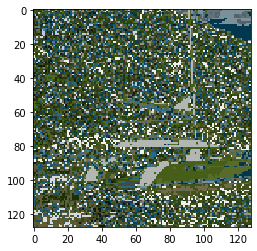

In [198]:
grayscale2rgb = np.zeros((original.shape[0], original.shape[1], 3))

for i in range(grayscale_transformed.shape[0]):
    for j in range(grayscale_transformed.shape[1]):
        grayscale2rgb[i,j] = gray2rgb[grayscale_transformed[i,j]]
        
plt.imshow(grayscale2rgb)

# Preprocess Training Data

In [242]:
from sklearn.preprocessing import LabelEncoder
# Training 

# x_train : (1, 65536)
x_rgb_train = grayscale_transformed.flatten().reshape(1, grayscale_transformed.shape[0]*grayscale_transformed.shape[1])
print(x_rgb_train.shape)

y_rgb_train = [','.join(str(val) for val in pixel) for pixel in lab_transformed.reshape(grayscale_transformed.shape[0]*grayscale_transformed.shape[1], 3)]
print(np.array(y_rgb_train).shape)
label_encoder = LabelEncoder()
y_rgb_train = np.array(label_encoder.fit_transform(y_rgb_train))

(1, 16384)
(16384,)


In [243]:
print(y_rgb_train.shape)
print(y_rgb_train)

(16384,)
[40 40 34 ... 16  6  6]


# Training

In [244]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

rgb_values = 128
examples = len(y_rgb_train)
m = examples

y_rgb_train = y_rgb_train.reshape(1, examples)
y_rgb_train = np.eye(rgb_values)[y_rgb_train.astype('int32')]
y_rgb_train = y_rgb_train.T.reshape(rgb_values, examples)



def compute_multiclass_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum

    return L

n_x = x_rgb_train.shape[0]
n_h = 128
learning_rate = 1

W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(rgb_values, n_h)
b2 = np.zeros((rgb_values, 1))

X = x_rgb_train
Y = y_rgb_train

print(Y.shape)
print(X.shape)
print(W1.shape)

(128, 16384)
(1, 16384)
(128, 1)


In [229]:
# Train the model

for i in range(200):

    Z1 = np.matmul(W1,X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2,A1) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

    cost = compute_multiclass_loss(Y, A2)

    dZ2 = A2-Y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)

print("Final cost:", cost)

Epoch 0 cost:  19.025262914298633
Epoch 100 cost:  3.6697730193179106
Final cost: 3.4997687650024014


In [203]:
from sklearn.metrics import classification_report, confusion_matrix

Z1 = np.matmul(W1, X) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

predictions = np.argmax(A2, axis=0)
labels = np.argmax(y_rgb_train, axis=0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[  0   0   0 ...   0   0   0]
 [329 325  99 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 680 128 506]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.97      0.26      0.41      1236
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.76      0.12      0.21      2387
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00        

In [204]:
print(predictions)

[26 26 18 ... 15  7  7]


In [205]:
reconstruction = []
print(label_encoder.inverse_transform(predictions))

for label in label_encoder.inverse_transform(predictions):
    
    reconstruction.append(np.array([float(x) for x in label.split(',')]))

['33.195703885125816,-16.913177416693543,29.02691505508323'
 '33.195703885125816,-16.913177416693543,29.02691505508323'
 '28.33352754168918,-17.45522883503812,28.246755205264105' ...
 '26.056614475264276,-14.109819575927952,24.266928722774576'
 '22.725215043735503,-10.315005543284496,19.832134284484052'
 '22.725215043735503,-10.315005543284496,19.832134284484052']


In [206]:
reconstruction_image = np.array(reconstruction).reshape(128,128,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


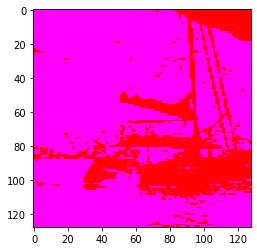

In [207]:
plt.imshow(reconstruction_image)

(128, 128, 3)


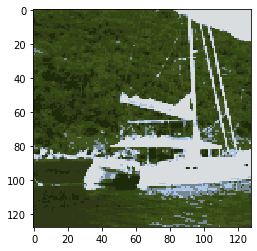

In [208]:
back2rgb = lab2rgb(reconstruction_image)
print(back2rgb.shape)
plt.imshow(back2rgb)